In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *
import sys
sys.path.append("../")
from utils.fehler_gauss import fehler_gauss
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

## Beugung Spalt

In [300]:
pos_spalt = 27e-3
u_pos_spalt = 3e-3

pos_laser = 1.5e-2
u_pos_laser = 5e-3

d_schirm_papier = 0.6e-2

u_ablese = 0.5e-3
u_messschieber = 0.05e-3

lambda_laser = 532e-9
u_lambda_laser = 1e-9

beugung_spalt = pd.read_excel("BUB.xlsx", sheet_name="LaserBeugungSpalt")
beugung_spalt[[i for i in range(1, 6)]] *= 1e-2 # Abstaende Minima in cm
beugung_spalt["Position Schirm"] *= 1e-2 # Position Schirm in cm
beugung_spalt

,Position Schirm,1,2,3,4,5
0,1.97,0.0159,0.0314,0.0469,0.06075,0.0752
1,1.30,0.0100,0.0185,0.0255,0.03500,0.0450
2,0.77,0.0055,0.0105,0.0145,0.01900,0.0235


$$\tan \alpha = \frac{s}{l}$$

Die Werte im DataFrame sind die Abstände zwischen zwei Minima gleicher Ordnung, also $2 s$.

$l$ ist der Abstand zwischen Spalt und Schirm

In [301]:
s = beugung_spalt[[i for i in range(1, 6)]] / 2
u_s = np.sqrt(u_messschieber**2 + u_ablese**2)

l = beugung_spalt["Position Schirm"] + d_schirm_papier - pos_spalt
u_l = np.sqrt(u_pos_spalt**2 + u_ablese**2 + u_messschieber**2)

s

,1,2,3,4,5
0,0.00795,0.01570,0.02345,0.030375,0.03760
1,0.00500,0.00925,0.01275,0.017500,0.02250
2,0.00275,0.00525,0.00725,0.009500,0.01175


In [302]:
# s durch l mit Fehlern berechnen
s_symbol, l_symbol = symbols("s l")
s_durch_l_formula = s_symbol / l_symbol

s_durch_l, u_s_durch_l = fehler_gauss(
    s_durch_l_formula,
    [s_symbol, l_symbol],
    [s.values, l.values.repeat(5).reshape(3, 5)],
    [u_s, u_l]
)
s_durch_l

array([[0.00407901, 0.00805541, 0.01203181, 0.01558492, 0.01929194],
       [0.0039093 , 0.00723221, 0.00996873, 0.01368256, 0.01759187],
       [0.00367156, 0.00700935, 0.00967957, 0.01268358, 0.01568758]])

Minima: $n \lambda = d \sin\alpha \approx d \frac{s}{l} \implies n \frac{\lambda}{d} = \frac{s}{l}$
Steigung aus linearer Regression: $m = \frac{\lambda}{d} \implies d = \frac{\lambda}{m}$

In [312]:
# s durch l in DataFrame
s_durch_l = pd.DataFrame(s_durch_l, columns=[i for i in range(1, 6)])
s_durch_l[[f"u_{i}" for i in range(1, 6)]] = u_s_durch_l

# exakt berechnete alphas
alphas = np.arctan(s / l.values.repeat(5, axis=0).reshape((3, 5)))

# durchschnittliche relative Abweichungen der Kleinwinkelnäherung
rel_abweichungen = ((alphas / s_durch_l) - 1).abs()[[i for i in range(1, 6)]].mean()
rel_abweichungen.mean() * 100 # durchschnittliche relative Abweichung in Prozent

np.float64(0.004595579860963522)

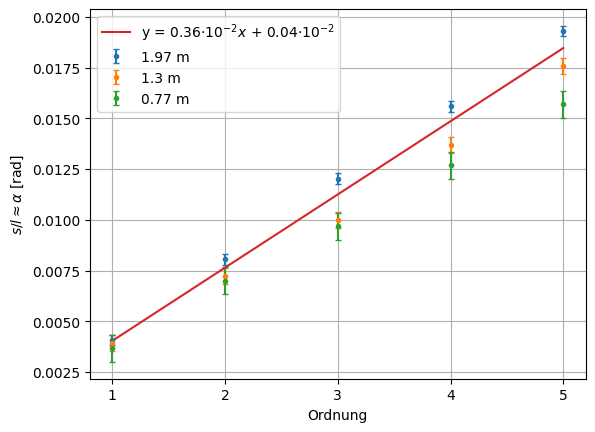

In [313]:
alphas_vals = s_durch_l[[i for i in range(1, 6)]]
alphas_errs = s_durch_l[[f"u_{i}" for i in range(1, 6)]]

# Regression s/l gegen Ordnung
def linear(x, m, b):
    return m * x + b

n = alphas_vals.columns.repeat(3).values.reshape((5, 3)).T.flatten()
popt, pcov = curve_fit(linear, n, alphas_vals.values.flatten(), sigma=alphas_errs.values.flatten())

X = np.linspace(n.min(), n.max(), 100)
Y = linear(X, *popt)

for i in range(0, 3):
    plt.errorbar(
        x=alphas_vals.columns,
        y=alphas_vals.iloc[i],
        fmt=".",
        capsize=2,
        yerr=alphas_errs.iloc[i],
        label=f"{beugung_spalt.iloc[i]["Position Schirm"]} m",
    )
fit_label = "y = " + \
    str(np.round(popt[0] * 100, 2)) + r"$\cdot 10^{-2} x$ + " + str(np.round(popt[1] * 100, 2)) + r"$\cdot 10^{-2}$"
plt.plot(X, Y, label=fit_label)
plt.grid(True)
plt.legend()
plt.xlabel("Ordnung")
plt.ylabel(r"$s/l \approx \alpha$ [rad]")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig("beugung_spalt.svg")

In [314]:
print("Steigung:", popt[0], "+-", np.sqrt(pcov[0, 0]))

Steigung: 0.0036049275588937815 +- 0.000170710636525413


In [315]:
lambda_symbol, m_symbol = symbols("lambda m")
d_formula = lambda_symbol / m_symbol

d_val, u_d = fehler_gauss(
    d_formula,
    [lambda_symbol, m_symbol],
    [lambda_laser, popt[0]],
    [u_lambda_laser, np.sqrt(pcov[0, 0])]
)
print("Spaltbreite:", d_val * 1e6, "+-", u_d * 1e6, "µm")

Spaltbreite: 147.57578101326706 +- 6.993925471298661 µm


## Beugung am Gitter

In [316]:
pos_schirm = np.array([63.5, 45.4, 34.1])
u_pos_schirm = 0.5e-3

pos_gitter = 6.7e-3
u_pos_gitter = 0.5e-3

dfs = {
    i: pd.read_excel("BUB.xlsx", sheet_name=f"Beugungsgitter{i}") for i in range(1, 4)
}
beugung_gitter = pd.concat(dfs)
beugung_gitter["Position Schirm"] = pos_schirm.repeat(5)
beugung_gitter *= 1e-2  # Abstaende Minima in cm
beugung_gitter

Blau  Gruen  Orange  Position Schirm
1 0  0.051  0.063   0.067            0.635
  1  0.102  0.128   0.135            0.635
  2  0.153  0.193   0.204            0.635
  3  0.179  0.259   0.273            0.635
  4    NaN  0.328   0.350            0.635
2 0  0.036  0.043   0.047            0.454
  1  0.074  0.088   0.093            0.454
  2  0.144  0.133   0.141            0.454
  3  0.178  0.179   0.191            0.454
  4  0.215  0.226   0.242            0.454
3 0  0.026  0.033   0.035            0.341
  1  0.051  0.064   0.067            0.341
  2  0.077  0.096   0.101            0.341
  3  0.105  0.128   0.137            0.341
  4  0.144  0.165   0.175            0.341

In [317]:
# s berechnen (Position Schirm - Position Gitter)
s_gitter = beugung_gitter[["Blau", "Gruen", "Orange"]] / 2
u_s_gitter = np.sqrt(u_messschieber**2 + u_ablese**2)
beugung_gitter[["s Blau", "s Gruen", "s Orange"]] = s_gitter

# l berechnen (Position Papier - Position Gitter)
l_gitter = beugung_gitter["Position Schirm"] + d_schirm_papier - pos_gitter
u_l_gitter = np.sqrt(u_pos_gitter**2 + u_ablese**2 + u_messschieber**2)
beugung_gitter["l"] = l_gitter

beugung_gitter

Blau  Gruen  Orange  Position Schirm  s Blau  s Gruen  s Orange       l
1 0  0.051  0.063   0.067            0.635  0.0255   0.0315    0.0335  0.6343
  1  0.102  0.128   0.135            0.635  0.0510   0.0640    0.0675  0.6343
  2  0.153  0.193   0.204            0.635  0.0765   0.0965    0.1020  0.6343
  3  0.179  0.259   0.273            0.635  0.0895   0.1295    0.1365  0.6343
  4    NaN  0.328   0.350            0.635     NaN   0.1640    0.1750  0.6343
2 0  0.036  0.043   0.047            0.454  0.0180   0.0215    0.0235  0.4533
  1  0.074  0.088   0.093            0.454  0.0370   0.0440    0.0465  0.4533
  2  0.144  0.133   0.141            0.454  0.0720   0.0665    0.0705  0.4533
  3  0.178  0.179   0.191            0.454  0.0890   0.0895    0.0955  0.4533
  4  0.215  0.226   0.242            0.454  0.1075   0.1130    0.1210  0.4533
3 0  0.026  0.033   0.035            0.341  0.0130   0.0165    0.0175  0.3403
  1  0.051  0.064   0.067            0.341  0.0255   0.0320    0.0335  0.3403
  2  0.077  0.096   0.101            0.341  0.0385   0.0480    0.0505  0.3403
  3  0.105  0.128   0.137            0.341  0.0525   0.0640    0.0685  0.3403
  4  0.144  0.165   0.175            0.341  0.0720   0.0825    0.0875  0.3403

In [320]:
# zeigen, dass die Kleinwinkelnäherung zu ungenau ist
alphas_kwn = s_gitter / l_gitter.repeat(3).values.reshape((15, -1))
alphas_exact = np.arctan(s_gitter / l_gitter.repeat(3).values.reshape((15, -1)))
rel_abweichungen = (np.abs(alphas_exact - alphas_kwn) / alphas_exact).dropna()
rel_abweichungen.values.mean() * 100  # in Prozent, größer als vorher

np.float64(0.7668924055128794)

## Brechung im Prisma

In [228]:
pd.read_excel("BUB.xlsx", sheet_name="PrismaQuecksilber")

,Farbe,mit,ohne
0,Orange,131.5,179.9
1,Blau,129.4,179.9
2,Gruen,131.6,180.1


In [19]:
pd.read_excel("BUB.xlsx", sheet_name="PrismaEnergiesparlampe")

,Farbe,mit,ohne
0,Orange,130.1,178.4
1,Blau,129.3,179.9
2,Gruen,130.9,179.4
3,Rot,131.6,179.5
